#### The purpose of this script is to compare reprogramming and neurogenesis, via:
* DE analysis within each cell cluster
* Gene clustering

# 0 Load packages <a name="loading"></a> 

In [1]:
import sys
import pickle
print(sys.executable)
print(sys.path)
print(sys.version)

/home2/s418610/.conda/envs/py37_res_diffxpy/bin/python
['/home2/s418610/jupyter_notebooks/Invivo_neuronal_reprogramming/Cluster_with_10x/Remapped_10X_data/Harmony.4/Reprogramming_vs_Neurogenesis/POv2', '', '/cm/shared/apps/cnvkit/0.9.5/lib/python3.6/site-packages', '/cm/shared/apps/python/3.6.4-anaconda/lib', '/cm/shared/apps/jupyterkernel-matlab/0.16.1/lib/python3.6/site-packages', '/cm/shared/apps/python/2.7.x-anaconda/lib', '/home2/s418610/.conda/envs/py37_res_diffxpy/lib/python37.zip', '/home2/s418610/.conda/envs/py37_res_diffxpy/lib/python3.7', '/home2/s418610/.conda/envs/py37_res_diffxpy/lib/python3.7/lib-dynload', '/home2/s418610/.local/lib/python3.7/site-packages', '/home2/s418610/.conda/envs/py37_res_diffxpy/lib/python3.7/site-packages', '/home2/s418610/.conda/envs/py37_res_diffxpy/lib/python3.7/site-packages/fa2-0.3.5-py3.7-linux-x86_64.egg', '/home2/s418610/.conda/envs/py37_res_diffxpy/lib/python3.7/site-packages/batchglm', '/home2/s418610/.conda/envs/py37_res_diffxpy/lib/py

In [2]:
import re
from pathlib import Path
import numpy as np
import pandas as pd
import scipy.sparse


import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import harmonypy as hm

In [3]:
%load_ext autoreload
%autoreload 2

import anndata
# import matplotlib.pyplot as plt
# import seaborn as sns
# import logging
import scipy.stats


In [4]:
import diffxpy.api as de

In [5]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3

print('numpy', np.__version__)
print('pandas', pd.__version__)
print('scipy', scipy.__version__)
# print('sklearn', sklearn.__version__)
# print('statsmodels', sm.__version__)
print('matplotlib', mpl.__version__)
print('seaborn', sns.__version__)

sc.logging.print_versions()

!date +%F

numpy 1.17.2
pandas 0.25.2
scipy 1.4.1
matplotlib 3.1.3
seaborn 0.9.0
scanpy==1.4.5.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.4.1 pandas==0.25.2 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1
2020-07-23


# 1 Load data

In [6]:
neural_data_dir = '/project/GCRB/Hon_lab/s418610/Projects/03.Invivo_neuronal_reprogramming/analysis/Cluster_with_10X_20k/data/10x_remapped/PipelineOrganized_v1/NeuralOnly/'

In [7]:
adata_neural = sc.read(neural_data_dir + 'POv2_NeuralOnly_postFiltering_log_pcs50_Harmony_louvain_ann.h5ad')

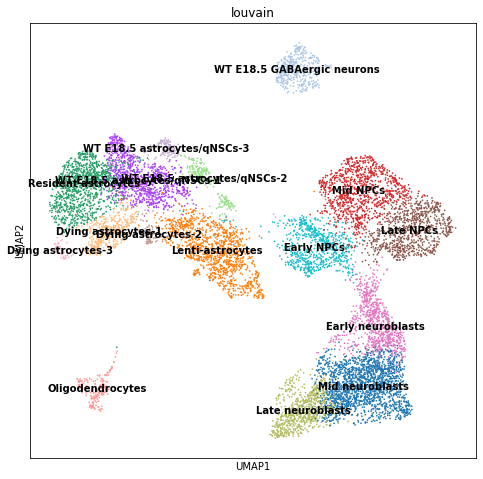

In [8]:
sc.pl.umap(adata_neural, color='louvain', legend_loc='on data')

# 2 Differential expression analysis

#### For each cluster on the trajectory, perform DE analysis between lenti-DLX2 cells and WT E18.5 cells
* Exclude resident astrocytes and WT E18.5 astrocytes/qNSCs (will compare resident astrocytes in a following section)
* Exclude WT E18.5 GABAergic neurons
* Exclude oligodendrocytes
* Exclude dying astrocytes
* Note: within WT E18.5 astrocytes/qNSCs-2, cells are clearly divided based on library, probably because BL41 cells got low lenti expr

Also, exclude all lenti-GFP control cells. 

### 2.1 Prepare dataset

#### Exclude lenti-GFP control cells

In [9]:
exclude = adata_neural.obs['library_name'] == 'BL42_control'

In [10]:
include = [not index for index in exclude]

In [11]:
assert sum(include) == 10170

In [12]:
adata_DE = adata_neural[include, :]

In [23]:
adata_DE

View of AnnData object with n_obs × n_vars = 10170 × 2499 
    obs: 'library_name', 'batch', 'lenti_count', 'lenti_log1p_count', 'tdT_count', 'tdT_log1p_count', 'n_counts', 'log_counts', 'n_genes', 'mt_count', 'mt_frac', 'n_counts_all', 'louvain'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_counts'
    uns: 'library_name_colors', 'louvain', 'louvain_colors', 'louvain_sizes', 'neighbors', 'paga', 'pca', 'umap'
    obsm: 'Harmony', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'

#### Exclude clusters not of interest

In [28]:
adata_DE.obs['louvain'].cat.categories

Index(['Mid neuroblasts', 'Lenti-astrocytes', 'Resident astrocytes',
       'Mid NPCs', 'WT E18.5 astrocytes/qNSCs-1', 'Late NPCs',
       'Early neuroblasts', 'Late neuroblasts', 'Early NPCs',
       'WT E18.5 GABAergic neurons', 'Dying astrocytes-1',
       'WT E18.5 astrocytes/qNSCs-2', 'Oligodendrocytes',
       'WT E18.5 astrocytes/qNSCs-3', 'Dying astrocytes-2',
       'Dying astrocytes-3'],
      dtype='object')

In [35]:
exclude = adata_DE.obs['louvain'].isin(['Resident astrocytes', 'WT E18.5 astrocytes/qNSCs-1', 
                                        'WT E18.5 astrocytes/qNSCs-2', 
                                        'WT E18.5 astrocytes/qNSCs-3', 
                                        'WT E18.5 GABAergic neurons', 
                                        'Oligodendrocytes', 'Dying astrocytes-1', 
                                        'Dying astrocytes-2', 'Dying astrocytes-3'])

In [36]:
include = [not index for index in exclude]

In [38]:
assert sum(include) == 6800

In [39]:
# Create an AnnData object for Clusters Of Interest (coi)
adata_DE_coi = adata_DE[include, :]

In [40]:
adata_DE_coi.var_names_make_unique()

In [41]:
adata_DE_coi.obs_names_make_unique()

In [42]:
adata_DE_coi

View of AnnData object with n_obs × n_vars = 6800 × 2499 
    obs: 'library_name', 'batch', 'lenti_count', 'lenti_log1p_count', 'tdT_count', 'tdT_log1p_count', 'n_counts', 'log_counts', 'n_genes', 'mt_count', 'mt_frac', 'n_counts_all', 'louvain'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_counts'
    uns: 'library_name_colors', 'louvain', 'louvain_colors', 'louvain_sizes', 'neighbors', 'paga', 'pca', 'umap'
    obsm: 'Harmony', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'

#### Create a separate object for astrocytes

In [45]:
include = adata_DE.obs['louvain'].isin(['Resident astrocytes', 
                                        'WT E18.5 astrocytes/qNSCs-1', 
                                        'WT E18.5 astrocytes/qNSCs-3'])

In [46]:
adata_DE_astro = adata_DE[include]

In [47]:
adata_DE_astro

View of AnnData object with n_obs × n_vars = 2101 × 2499 
    obs: 'library_name', 'batch', 'lenti_count', 'lenti_log1p_count', 'tdT_count', 'tdT_log1p_count', 'n_counts', 'log_counts', 'n_genes', 'mt_count', 'mt_frac', 'n_counts_all', 'louvain'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_counts'
    uns: 'library_name_colors', 'louvain', 'louvain_colors', 'louvain_sizes', 'neighbors', 'paga', 'pca', 'umap'
    obsm: 'Harmony', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'

In [48]:
adata_DE_astro.obs['library_name'].value_counts()

BL41_reprogrammed    863
10X_sample11         635
10X_sample51         603
Name: library_name, dtype: int64

### 2.2 Perform DE analysis within each cluster for 100 iterations

In [26]:
import random

In [43]:
df = pd.DataFrame()

test_list = []
for cluster in adata_DE_coi.obs['louvain'].cat.categories:
#    print('Current cluster is', cluster)
#    print(adata_DE_coi[adata_DE_coi.obs['louvain']==cluster].obs['library_name'].value_counts())
    df[cluster] = adata_DE_coi[adata_DE_coi.obs['louvain']==cluster].obs['library_name'].value_counts()

df = df.T

In [44]:
# Summarize numbers of cells within each cluster
df_new = pd.DataFrame(data={
    'lenti-DLX2': df['BL41_reprogrammed'].values, 
    'WT E18.5': (df['10X_sample11']+df['10X_sample51']).values
}, index=df.index)

df_new

,lenti-DLX2,WT E18.5
Mid neuroblasts,977,772
Lenti-astrocytes,761,324
Mid NPCs,102,843
Late NPCs,224,594
Early neuroblasts,638,146
Late neuroblasts,557,170
Early NPCs,201,491


In light of these, for each iteration of DE analysis, we will randomly select 70 lenti-DLX2 cells and 70 WT E18.5 cells. We will repeat this 100 times for each cell type. 

In [ ]:
test_list_collection = []
for _ in range(100):
    # Initialize an empty test_list
    test_list = []
    print('Current iteration:', _)

    # DE test for all clusters except resident astrocytes
    for cluster in adata_DE_coi.obs['louvain'].cat.categories:
        adata_DE_test = adata_DE_coi[adata_DE_coi.obs['louvain']==cluster]

        index_include = random.choices(adata_DE_test.obs.index[adata_DE_test.obs['batch'] == 'experiment'], k=70)
        index_include = index_include + random.choices(adata_DE_test.obs.index[adata_DE_test.obs['batch'] == '10X'], k=70)

        adata_DE_test = adata_DE_test[index_include]

        adata_DE_test = anndata.AnnData(X=adata_DE_test.raw.X, 
                                       obs=adata_DE_test.obs, 
                                       var=adata_DE_test.raw.var)

        adata_DE_test.var_names_make_unique()

        # Use two-sample wrapper from diffxpy
        test_cluster = de.test.two_sample(data=adata_DE_test, 
                                          grouping='batch', 
                                          test='rank')

        test_list.append((cluster, test_cluster))

    # DE test for resident astrocytes
    index_include = random.choices(adata_DE_astro.obs.index[adata_DE_astro.obs['batch'] == 'experiment'], k=70)
    index_include = index_include + random.choices(adata_DE_astro.obs.index[adata_DE_astro.obs['batch'] == '10X'], k=70)
    
    adata_DE_test = adata_DE_astro.copy()
    adata_DE_test = adata_DE_test[index_include]


    adata_DE_test = anndata.AnnData(X=adata_DE_test.raw.X, 
                                   obs=adata_DE_test.obs, 
                                   var=adata_DE_test.raw.var)

    adata_DE_test.var_names_make_unique()

    # Use two-sample wrapper
    test_astro = de.test.two_sample(data=adata_DE_test, 
                                      grouping='batch', 
                                      test='rank')
    test_list.append(('Resident_astrocytes', test_astro))
    
    test_list_collection.append(test_list)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Current iteration: 0


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 1


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 2


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 3


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 4


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 5


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 6


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 7


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 8


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 9


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 10


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 11


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 12


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 13


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 14


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 15


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 16


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 17


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 18


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 19


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 20


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 21


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 22


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 23


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 24


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 25


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 26


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 27


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 28


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 29


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 30


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 31


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 32


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 33


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 34


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 35


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 36


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 37


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 38


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 39


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 40


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 41


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 42


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 43


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 44


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 45


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 46


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 47


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 48


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 49


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 50


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 51


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 52


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 53


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 54


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 55


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 56


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 57


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 58


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 59


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 60


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 61


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 62


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 63


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 64


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 65


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 66


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 67


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 68


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 69


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 70


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 71


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Current iteration: 72


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [53]:
assert len(test_list_collection)==100

##### Write and read data

In [49]:
int_out_dir = '/project/GCRB/Hon_lab/s418610/Projects/03.Invivo_neuronal_reprogramming/analysis/11.DE_repr_vs_neurog/intermediates/'

In [38]:
output_path = int_out_dir + 'test_list_collection_100iter'

with open(output_path, 'wb') as output_file:
 
    pickle.dump(test_list_collection, output_file)

In [50]:
input_path = int_out_dir + 'test_list_collection_100iter'
with open(input_path, 'rb') as input_file:
 
    test_list_collection = pickle.load(input_file)

In [52]:
assert len(test_list_collection)==100

### 2.3 Extract data from results

In [54]:
# Extract numbers of genes up in lenti-DLX2 cells with q value < 0.01 and fold change > 2 from each cell type
data_experimental_up = {}
for i, iteration in enumerate(test_list_collection):
    tmp_data = []
    for cluster, test_cluster in iteration:
        tmp_data.append(sum(np.logical_and(test_cluster.summary()['qval'] < 0.01, test_cluster.summary()['log2fc'] > 1)))
    data_experimental_up[i] = tmp_data

df_experimental_up = pd.DataFrame(data_experimental_up)

clusters = {}
for i, (cluster, _) in enumerate(test_list_collection[0]):
    clusters[i] = cluster
df_experimental_up.rename(index=clusters, inplace=True)

In [55]:
# Extract numbers of genes up in WT E18.5 cells with q value < 0.01 and fold change > 2 from each cell type
data_public_up = {}
for i, iteration in enumerate(test_list_collection):
    tmp_data = []
    for cluster, test_cluster in iteration:
        tmp_data.append(sum(np.logical_and(test_cluster.summary()['qval'] < 0.01, test_cluster.summary()['log2fc'] < -1)))
    data_public_up[i] = tmp_data

df_public_up = pd.DataFrame(data_public_up)

clusters = {}
for i, (cluster, _) in enumerate(test_list_collection[0]):
    clusters[i] = cluster
df_public_up.rename(index=clusters, inplace=True)

### 2.4 Plot the results

In [56]:
df_experimental_up['mean'] = df_experimental_up.mean(axis=1)

In [57]:
df_experimental_up['std'] = df_experimental_up.std(axis=1)

In [58]:
df_experimental_up

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,mean,std
0-Mid-neuroblasts,201,286,180,257,251,258,333,158,310,244,...,306,166,173,203,188,229,289,215,217.70,50.600099
1-Reprogrammed_astrocytes/qNSC-like,754,747,713,503,732,514,571,785,885,652,...,528,585,797,524,723,789,717,683,664.45,111.026517
3-Mid-aNSCs,2173,2687,1937,1781,1856,2134,2353,2111,2577,2195,...,2098,1895,1379,2705,2259,1659,2424,2233,2149.11,452.152096
5-Late-aNSCs/NPC-like,467,453,522,615,422,759,744,535,549,621,...,406,417,881,457,488,379,643,637,545.76,160.572234
6-NPC/early-neurobalsts,327,130,147,151,162,131,171,199,123,141,...,208,209,180,160,168,122,191,200,180.67,51.000599
7-Late-neuroblats/maturing_neurons,177,209,173,268,367,161,192,143,217,135,...,222,191,197,299,121,195,185,215,210.30,46.023146
8-Early-aNSCs,1319,1213,1211,1556,938,1481,834,1209,1638,1386,...,1132,1382,1050,1361,1238,1170,875,1822,1207.63,259.400025
11-Resident_astrocytes-1,603,682,839,760,691,695,718,693,757,627,...,697,768,703,639,882,578,581,694,710.12,94.064795
Resident_astrocytes,722,680,701,706,649,706,565,613,656,637,...,768,692,770,735,755,695,657,779,682.08,58.474555


In [59]:
df_public_up['mean'] = df_public_up.mean(axis=1)

In [60]:
df_public_up['std'] = df_public_up.std(axis=1)

In [61]:
df_public_up

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,mean,std
0-Mid-neuroblasts,40,38,55,44,38,52,36,48,39,48,...,40,48,44,46,48,44,37,33,44.33,7.503406
1-Reprogrammed_astrocytes/qNSC-like,432,404,348,574,352,600,495,455,363,432,...,507,577,317,535,414,482,477,491,463.46,84.406803
3-Mid-aNSCs,123,93,138,166,126,115,126,116,105,125,...,139,148,143,114,107,139,118,144,129.48,18.101094
5-Late-aNSCs/NPC-like,187,155,132,135,160,122,120,126,124,141,...,135,191,86,135,155,176,122,178,144.64,26.026341
6-NPC/early-neurobalsts,29,43,55,57,63,83,53,39,53,45,...,36,55,44,34,43,59,39,30,47.77,15.220286
7-Late-neuroblats/maturing_neurons,20,26,23,20,18,28,29,25,15,38,...,17,24,19,21,22,21,22,17,22.15,5.002749
8-Early-aNSCs,58,59,83,69,98,66,60,73,52,67,...,54,59,53,58,63,61,81,62,65.39,9.710711
11-Resident_astrocytes-1,962,714,777,632,705,559,619,971,385,809,...,588,667,572,753,452,538,943,654,701.50,178.415330
Resident_astrocytes,772,1106,898,861,821,880,1274,1188,1437,940,...,730,1007,843,811,1110,918,1018,1069,1065.05,187.909307


In [19]:
# row_order = ['Resident_astrocytes', '1-Reprogrammed_astrocytes/qNSC-like', '8-Early-aNSCs', 
#             '3-Mid-aNSCs', '5-Late-aNSCs/NPC-like', '6-NPC/early-neurobalsts', 
#             '0-Mid-neuroblasts', '7-Late-neuroblats/maturing_neurons']

In [63]:
row_order = ['Resident astrocytes', 'Lenti-astrocytes', 'Early NPCs', 
            'Mid NPCs', 'Late NPCs', 'Early neuroblasts', 
            'Mid neuroblasts', 'Late neuroblasts']

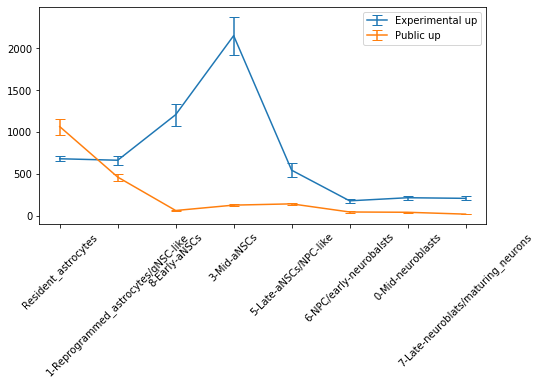

In [20]:
# Figure 3E, top
fig, ax = plt.subplots(figsize=(8,4))
x = np.arange(len(row_order))

y_experimental_up = df_experimental_up.loc[row_order]['mean']
error_experimental_up = df_experimental_up.loc[row_order]['std']

y_public_up = df_public_up.loc[row_order]['mean']
error_public_up = df_public_up.loc[row_order]['std']

plt.errorbar(x, y_experimental_up, error_experimental_up/2, capsize=5)
plt.errorbar(x, y_public_up, error_public_up/2, capsize=5)

plt.xticks(x, row_order, rotation=45)
plt.legend(['Experimental up', 'Public up'], loc='best')

# plt.savefig('/project/GCRB/Hon_lab/s418610/Projects/03.Invivo_neuronal_reprogramming/99.Manuscript/Figures_v2/linechart_n_DEGs_100iter_MT.pdf')
plt.show()

### Explore commonly differentially expressed genes across all cell types (these are likely result of batch effect)

In [64]:
test_list_all = test_list_collection[0]

In [65]:
from collections import Counter

In [66]:
experiment_up_list = []

In [67]:
for _, test_instance in test_list_all:
    experiment_up_list.append(test_instance.summary()[np.logical_and(test_instance.summary()['qval'] < 1e-10, test_instance.summary()['log2fc'] > 2)]['gene'].tolist())

In [68]:
assert len(experiment_up_list) == 9

In [69]:
# The genes that show enrichment in experimental cells in every cluster
set(experiment_up_list[0]).intersection(*experiment_up_list)

{'AY036118', 'Gm42418', 'Lars2'}

In [70]:
experiment_up_flat = [gene for gene_list in experiment_up_list for gene in gene_list]

In [71]:
counter_experiment_up = Counter(experiment_up_flat)

([<matplotlib.axis.XTick at 0x7fff44feab70>,
 <a list of 10 Text xticklabel objects>)

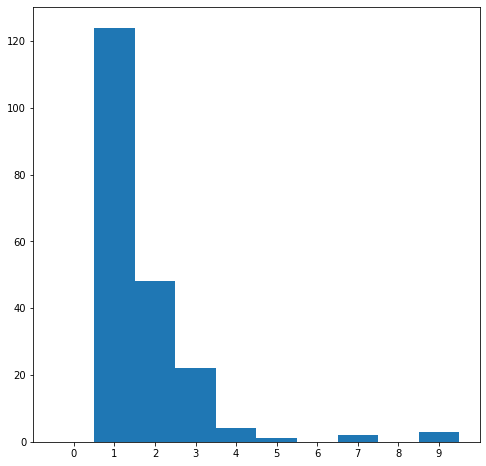

In [72]:
plt.hist([i for gene, i in counter_experiment_up.most_common()], 
        bins=[i-0.5 for i in range(11)], 
        histtype='bar')
plt.xticks(ticks=range(10))

In [73]:
counter_experiment_up.most_common(20)

[('Lars2', 9),
 ('Gm42418', 9),
 ('AY036118', 9),
 ('Ifi27', 7),
 ('tdTomato-WPRE-bGHpA', 7),
 ('Lenti-hGfa-Dlx2-IRES-GFP', 5),
 ('Hnrnpa0', 4),
 ('Gpr37l1', 4),
 ('Scg3', 4),
 ('Nrxn1', 4),
 ('Hist1h1e', 3),
 ('Acsl3', 3),
 ('Car2', 3),
 ('Fxyd1', 3),
 ('Crym', 3),
 ('Fam107a', 3),
 ('Cldn10', 3),
 ('Dhrs7', 3),
 ('Tspo', 3),
 ('Lsamp', 3)]

#### Examine genes enriched in public cells

In [74]:
public_up_list = []

In [75]:
for _, test_instance in test_list_all:
    public_up_list.append(test_instance.summary()[np.logical_and(test_instance.summary()['qval'] < 1e-10, test_instance.summary()['log2fc'] < -2)]['gene'].tolist())

In [76]:
assert len(public_up_list) == 9

In [77]:
set(public_up_list[0]).intersection(*public_up_list)

{'Rpl10', 'Rpl27', 'Rps12', 'Rps27'}

In [78]:
public_up_flat = [gene for gene_list in public_up_list for gene in gene_list]

In [79]:
counter_public_up = Counter(public_up_flat)

([<matplotlib.axis.XTick at 0x7fff4562b390>,
 <a list of 10 Text xticklabel objects>)

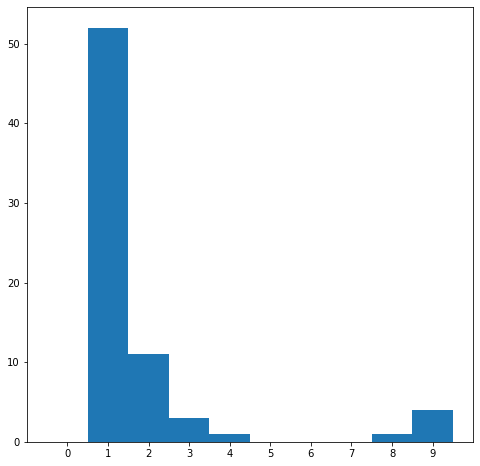

In [80]:
plt.hist([i for gene, i in counter_public_up.most_common()], 
        bins=[i-0.5 for i in range(11)], 
        histtype='bar')
plt.xticks(ticks=range(10))

In [81]:
counter_public_up.most_common(20)

[('Rpl10', 9),
 ('Rps27', 9),
 ('Rps12', 9),
 ('Rpl27', 9),
 ('Rpl9', 8),
 ('Gm10076', 4),
 ('Snrpg', 3),
 ('Uba52', 3),
 ('Igfbp2', 3),
 ('Lhx2', 2),
 ('Marcksl1', 2),
 ('Tmsb10', 2),
 ('Fxyd6', 2),
 ('Tspan13', 2),
 ('Rlbp1', 2),
 ('Neurog2', 2),
 ('Neurod6', 2),
 ('Tnc', 2),
 ('Creb5', 2),
 ('Fabp7', 2)]